In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

### 载入数据集

In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

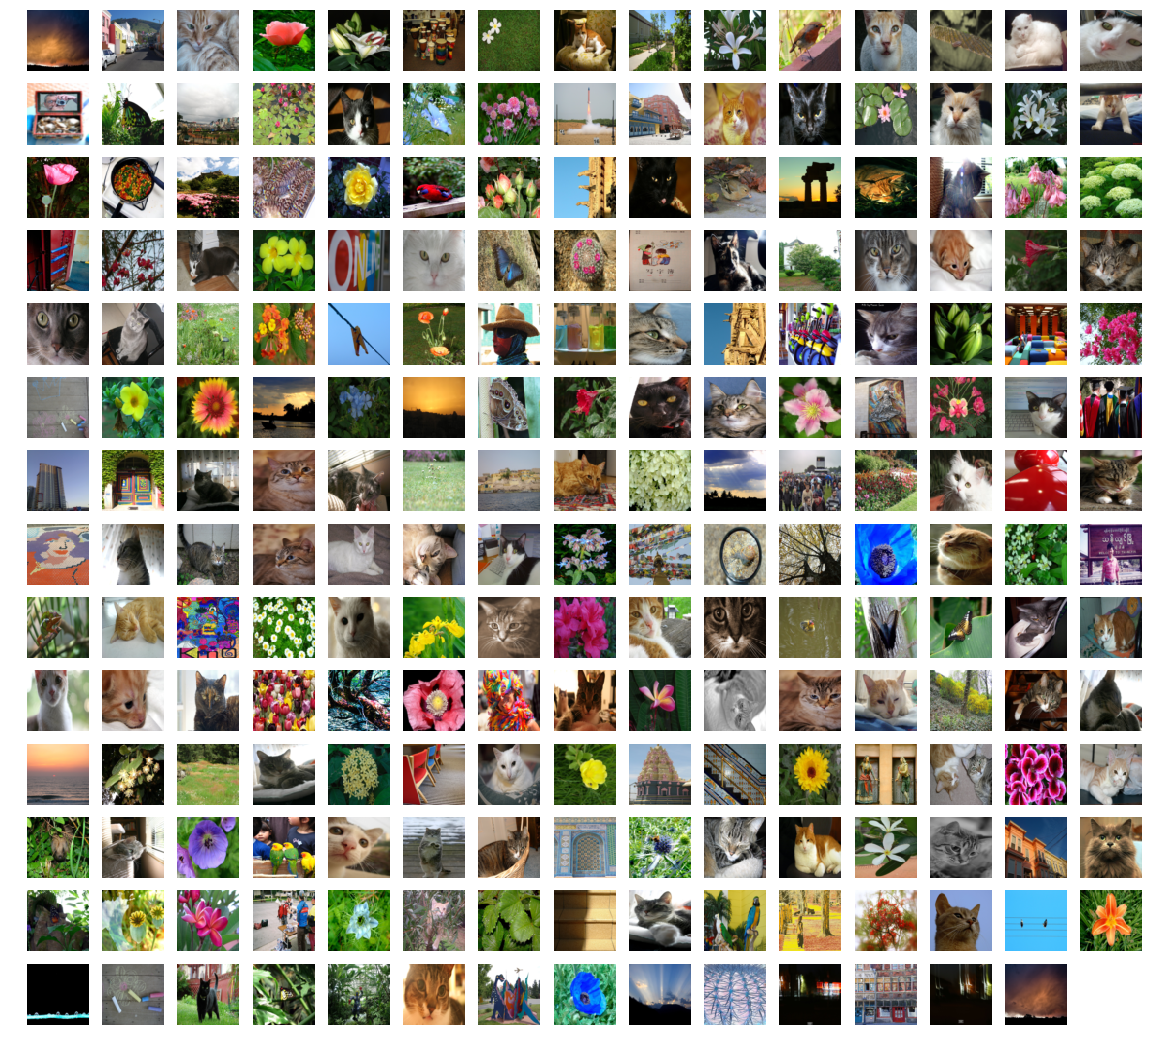

In [4]:
# 绘制训练样本图片集
X_orig = train_x_orig
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

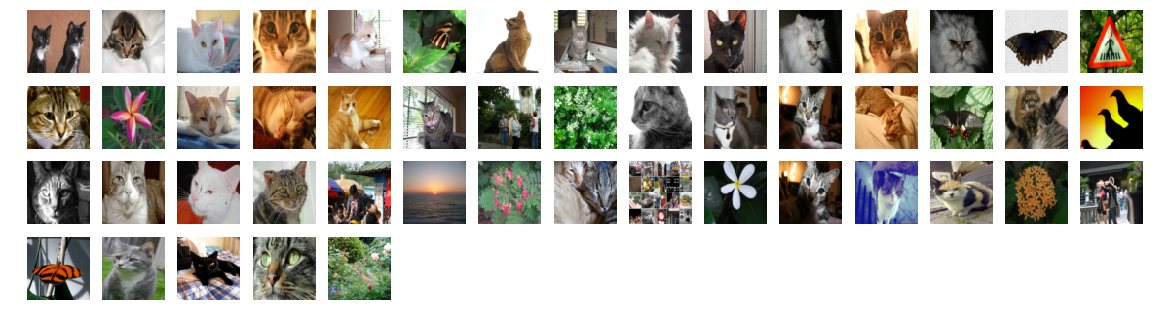

In [5]:
# 绘制测试样本图片集
X_orig = test_x_orig
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

### 标准化输入

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


### 深层神经网络（隐藏层ReLU 输出层sigmoid）

In [7]:
# sigmoid激活函数
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# ReLU激活函数
def relu(Z):
    return np.maximum(0, Z)

In [8]:
# 初始化深层神经网络的参数 使用HE初始化
def initialize_parameters_he(layers_dims, lambd = 1):
    parameters = {}
    
    # 深层神经网络的层数（包含0层）
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(lambd * 2 / layers_dims[l - 1]) # HE初始化
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [9]:
# 计算带Dropout正则化的正向传播 ReLU->ReLU->...->Sigmoid
def forward_propagate_with_dropout(parameters, X, keep_prob = 1):
    L = len(parameters) // 2
    
    caches = {}
    
    A = X
    caches['A0'] = A
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        D = np.random.rand(Z.shape[0], Z.shape[1]) < keep_prob # dropout mask
        A = relu(Z) * D / keep_prob
        caches['A' + str(l)] = A
        caches['D' + str(l)] = D
    
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    A = sigmoid(Z)
    caches['A' + str(L)] = A
    
    return A, caches

In [10]:
# 计算损失函数 cross-entropy cost
def compute_cost(AL, Y):
    logprobs = Y * np.log(AL) + (1 - Y) * np.log(1 - AL) # 可能会出现log(0)的情况，此时log(0)=-inf，不影响反向传播计算
    cost = -np.nanmean(logprobs) # 过滤掉出现-inf的数据
    return cost

In [11]:
# 计算带Dropout正则化的反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate_with_dropout(parameters, Y, caches, keep_prob = 1):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = dZ @ caches['A' + str(L - 1)].T / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * caches['D' + str(l)] / keep_prob * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = dZ @ caches['A' + str(l - 1)].T / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

### 梯度检验

In [12]:
def gradient_check(parameters, grads, X, Y, epsilon = 1e-7):
    L = len(parameters) // 2
    
    grad = []
    gradapprox = []
    
    for l in range(1, L + 1):
        idx = ["W" + str(l), "b" + str(l)]
        didx = ["dW" + str(l), "db" + str(l)]
        for k in range(2):
            T = parameters[idx[k]]
            dT = grads[didx[k]]
            
            assert(T.shape == dT.shape)
            
            for i in range(T.shape[0]):
                for j in range(T.shape[1]):
                    pre = T[i, j]

                    parameters[idx[k]][i, j] = pre + epsilon
                    AL, _ = forward_propagate_with_dropout(parameters, X)
                    J_plus = compute_cost(AL, Y)

                    parameters[idx[k]][i, j] = pre - epsilon
                    AL, _ = forward_propagate_with_dropout(parameters, X)
                    J_minus = compute_cost(AL, Y)

                    parameters[idx[k]][i, j] = pre

                    gradapprox.append((J_plus - J_minus) / epsilon / 2)
                    grad.append(dT[i][j]) 
    
    grad = np.array(grad)
    gradapprox = np.array(gradapprox)
    
    difference = np.linalg.norm(grad - gradapprox) / (np.linalg.norm(grad) + np.linalg.norm(gradapprox))
    
    if difference > epsilon:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

In [13]:
# 进行一次正反向传播计算的梯度检验
np.random.seed(2)
X = np.random.randn(100, 20)
Y = np.random.randint(0, 2, (1, 20))
parameters = initialize_parameters_he([X.shape[0], 20, 7, 5, 1])
AL, caches = forward_propagate_with_dropout(parameters, X)
grads = backward_propagate_with_dropout(parameters, Y, caches)
difference = gradient_check(parameters, grads, X, Y)

Your backward propagation works perfectly fine! difference = 1.42078152016e-08


### 深层神经网络模型

In [14]:
# 用梯度下降法更新参数
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    
    return parameters

In [15]:
def L_layer_model_with_dropout(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = False, keep_prob = 1):
    # 初始化参数 W1 b1 ... WL bL
    parameters = initialize_parameters_he(layers_dims, lambd=0.5) # lambd取0.5时模型效果最好
    
    # 损失函数记录
    costs = []
    
    # 梯度下降法循环迭代
    for i in range(num_iterations):
        AL, caches = forward_propagate_with_dropout(parameters, X, keep_prob)
        if print_cost:
            if i % 100 == 0:
                cost = compute_cost(AL, Y)
                costs.append(cost)
                if i % 100 == 0:
                    print ("Cost after iteration %i: %f" %(i, cost))
        grads = backward_propagate_with_dropout(parameters, Y, caches, keep_prob)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    # 绘制损失函数
    if print_cost:
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [16]:
# 对样本进行预测（二元分类）
def predict(parameters, X):
    AL, caches = forward_propagate_with_dropout(parameters, X)
    AL = AL > 0.5
    return AL.astype(np.int)

In [17]:
# 计算准确率
def compute_accuracy(parameters, X, Y):
    P = predict(parameters, X)
    return float((Y @ P.T + (1 - Y) @ (1 - P.T)) / float(Y.size))

### 尝试不同的神经网络超参数

In [18]:
layers_dims_set = [[train_x.shape[0], 20, 7, 5, 1],
                   [train_x.shape[0], 20, 5, 1],
                   [train_x.shape[0], 20, 1],
                   [train_x.shape[0], 40, 10, 5, 1],
                   [train_x.shape[0], 40, 5, 1],
                  ]
for layers_dims in layers_dims_set:
    np.random.seed(1)
    parameters = L_layer_model_with_dropout(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = False)
    print('网络节点数:', layers_dims)
    print('训练集准确率: %d' % float(compute_accuracy(parameters, train_x, train_y) * 100) + '%')
    print('测试集准确率: %d' % float(compute_accuracy(parameters, test_x, test_y) * 100) + '%')
    print()

网络节点数: [12288, 20, 7, 5, 1]
训练集准确率: 98%
测试集准确率: 80%

网络节点数: [12288, 20, 5, 1]
训练集准确率: 100%
测试集准确率: 78%

网络节点数: [12288, 20, 1]
训练集准确率: 100%
测试集准确率: 76%

网络节点数: [12288, 40, 10, 5, 1]
训练集准确率: 100%
测试集准确率: 80%

网络节点数: [12288, 40, 5, 1]
训练集准确率: 100%
测试集准确率: 74%



### 开启Dropout正则化，减少过拟合

In [19]:
layers_dims_set = [[train_x.shape[0], 20, 7, 5, 1],
                   [train_x.shape[0], 20, 5, 1],
                   [train_x.shape[0], 20, 1],
                   [train_x.shape[0], 40, 10, 5, 1],
                   [train_x.shape[0], 40, 5, 1],
                  ]
for layers_dims in layers_dims_set:
    np.random.seed(1)
    parameters = L_layer_model_with_dropout(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = False, keep_prob = 0.86)
    print('网络节点数:', layers_dims)
    print('训练集准确率: %d' % float(compute_accuracy(parameters, train_x, train_y) * 100) + '%')
    print('测试集准确率: %d' % float(compute_accuracy(parameters, test_x, test_y) * 100) + '%')
    print()

网络节点数: [12288, 20, 7, 5, 1]
训练集准确率: 100%
测试集准确率: 78%

网络节点数: [12288, 20, 5, 1]
训练集准确率: 100%
测试集准确率: 80%

网络节点数: [12288, 20, 1]
训练集准确率: 100%
测试集准确率: 74%

网络节点数: [12288, 40, 10, 5, 1]
训练集准确率: 100%
测试集准确率: 78%

网络节点数: [12288, 40, 5, 1]
训练集准确率: 100%
测试集准确率: 74%



In [20]:
layers_dims = [train_x.shape[0], 20, 5, 1]
keep_prob_set = [0.5, 0.6, 0.7, 0.8, 0.9]
for keep_prob in keep_prob_set:
    np.random.seed(1)
    parameters = L_layer_model_with_dropout(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = False, keep_prob = keep_prob)
    print('网络节点数:', layers_dims, 'keep prob:', keep_prob)
    print('训练集准确率: %d' % float(compute_accuracy(parameters, train_x, train_y) * 100) + '%')
    print('测试集准确率: %d' % float(compute_accuracy(parameters, test_x, test_y) * 100) + '%')
    print()

网络节点数: [12288, 20, 5, 1] keep prob: 0.5
训练集准确率: 100%
测试集准确率: 78%

网络节点数: [12288, 20, 5, 1] keep prob: 0.6
训练集准确率: 100%
测试集准确率: 78%

网络节点数: [12288, 20, 5, 1] keep prob: 0.7
训练集准确率: 100%
测试集准确率: 74%

网络节点数: [12288, 20, 5, 1] keep prob: 0.8
训练集准确率: 100%
测试集准确率: 76%

网络节点数: [12288, 20, 5, 1] keep prob: 0.9
训练集准确率: 100%
测试集准确率: 72%



### 选择最优超参数进行预测

Cost after iteration 0: 0.710903
Cost after iteration 100: 0.579010
Cost after iteration 200: 0.496949
Cost after iteration 300: 0.509303
Cost after iteration 400: 0.398341
Cost after iteration 500: 0.384169
Cost after iteration 600: 0.384324
Cost after iteration 700: 0.352655
Cost after iteration 800: 0.272140
Cost after iteration 900: 0.232073
Cost after iteration 1000: 0.205023
Cost after iteration 1100: 0.179984
Cost after iteration 1200: 0.166686
Cost after iteration 1300: 0.155808
Cost after iteration 1400: 0.112792
Cost after iteration 1500: 0.118642
Cost after iteration 1600: 0.109430
Cost after iteration 1700: 0.108636
Cost after iteration 1800: 0.078704
Cost after iteration 1900: 0.081478
Cost after iteration 2000: 0.081334
Cost after iteration 2100: 0.094902
Cost after iteration 2200: 0.074941
Cost after iteration 2300: 0.094115
Cost after iteration 2400: 0.066349


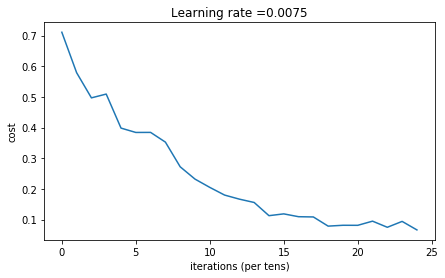

In [21]:
np.random.seed(1)
layers_dims = [train_x.shape[0], 20, 5, 1]
parameters = L_layer_model_with_dropout(train_x, train_y, layers_dims, learning_rate = 0.0075, num_iterations = 2500, print_cost = True, keep_prob = 0.86)

In [22]:
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_x, train_y) * 100) + '%')
print('测试集准确率: %d' % float(compute_accuracy(parameters, test_x, test_y) * 100) + '%')

训练集准确率: 100%
测试集准确率: 80%


### 显示预测错误的图片

In [23]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    num_images = len(mislabeled_indices[0])
    row = 10
    col = np.ceil(num_images / row)
    plt.rcParams['figure.figsize'] = (20, 20 * col / row)
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(col, row, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')

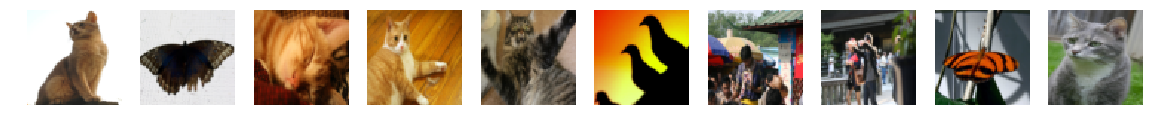

In [24]:
print_mislabeled_images(classes, test_x, test_y, predict(parameters, test_x))